In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels as sm
import warnings
warnings.filterwarnings("ignore")

##data modelling
import sklearn
from sklearn.model_selection import train_test_split

## Rescaling 
from sklearn.preprocessing import MinMaxScaler

##regression
import statsmodels.api as sm

##vif
from statsmodels.stats.outliers_influence import variance_inflation_factor

## RFE
from sklearn.feature_selection import RFE
from sklearn.linear_model import LinearRegression

from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Step 1 : Reading and analyzing data

In [3]:
# read dataset
rentals = pd.read_csv('./day.csv')
rentals.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,01-01-2018,1,0,1,0,6,0,2,14.110847,18.18125,80.5833,10.749882,331,654,985
1,2,02-01-2018,1,0,1,0,0,0,2,14.902598,17.68695,69.6087,16.652113,131,670,801
2,3,03-01-2018,1,0,1,0,1,1,1,8.050924,9.47025,43.7273,16.636703,120,1229,1349
3,4,04-01-2018,1,0,1,0,2,1,1,8.200000,10.60610,59.0435,10.739832,108,1454,1562
4,5,05-01-2018,1,0,1,0,3,1,1,9.305237,11.46350,43.6957,12.522300,82,1518,1600


In [4]:
rentals.shape

(730, 16)

In [5]:
rentals.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 730 entries, 0 to 729
Data columns (total 16 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   instant     730 non-null    int64  
 1   dteday      730 non-null    object 
 2   season      730 non-null    int64  
 3   yr          730 non-null    int64  
 4   mnth        730 non-null    int64  
 5   holiday     730 non-null    int64  
 6   weekday     730 non-null    int64  
 7   workingday  730 non-null    int64  
 8   weathersit  730 non-null    int64  
 9   temp        730 non-null    float64
 10  atemp       730 non-null    float64
 11  hum         730 non-null    float64
 12  windspeed   730 non-null    float64
 13  casual      730 non-null    int64  
 14  registered  730 non-null    int64  
 15  cnt         730 non-null    int64  
dtypes: float64(4), int64(11), object(1)
memory usage: 91.4+ KB


In [6]:
#Missing values
rentals.isnull().sum()

instant       0
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

### Filtering redundant columns 

In [7]:
df = rentals[rentals.columns.difference(['instant','dteday','atemp'])]
df.head()

,casual,cnt,holiday,hum,mnth,registered,season,temp,weathersit,weekday,windspeed,workingday,yr
0,331,985,0,80.5833,1,654,1,14.110847,2,6,10.749882,0,0
1,131,801,0,69.6087,1,670,1,14.902598,2,0,16.652113,0,0
2,120,1349,0,43.7273,1,1229,1,8.050924,1,1,16.636703,1,0
3,108,1562,0,59.0435,1,1454,1,8.200000,1,2,10.739832,1,0
4,82,1600,0,43.6957,1,1518,1,9.305237,1,3,12.522300,1,0


### Data modification

#### Dictionary mapping for Categorical variables for better interpretation

In [8]:
weekdic = {
    0:'Monday',1:'Tuesday',2:'Wednesday',3:'Thursday',4:'Friday',5:'Saturday',6:'Sunday'
}
weekOrder = ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
monthdic = {
    1:'January',2:'February',3:'March',4:'April',5:'May',6:'June',
    7:'July',8:'August',9:'September',10:'October',11:'November',12:'December'}
monthOrder = ['January','February','March','April','May','June','July','August','September','October','November','December']
#yeardic = {
#    0:'2018',1:'2019'
#}
#yearOrder = ['2018','2019']
seasondic = {
    1:'spring', 2:'summer', 3:'fall', 4:'winter'
}
seasonOrder = ['spring','summer','fall','winter']
weathersitdic = {
    1:'Clear', 2:'Mist', 3:'Light snow', 4:'Heavy rain'
}
weathersitorder = ['Clear','Mist','Light snow','Heavy rain']

In [9]:
df['weekday'] = df['weekday'].map(weekdic)
df['weekday'] = df.weekday.astype("category")
df.weekday.cat.set_categories(weekOrder, inplace=True)

df['mnth'] = df['mnth'].map(monthdic)
df.mnth = df.mnth.astype("category")
df.mnth.cat.set_categories(monthOrder, inplace=True)

#df['yr'] = df['yr'].map(yeardic)
#df.yr = df.yr.astype("category")
#df.yr.cat.set_categories(yearOrder, inplace=True)

df['season'] = df['season'].map(seasondic)
df.season = df.season.astype("category")
df.season.cat.set_categories(seasonOrder, inplace=True)

df['weathersit'] = df['weathersit'].map(weathersitdic)
df.weathersit = df.weathersit.astype("category")
df.weathersit.cat.set_categories(weathersitorder, inplace=True)

In [10]:
df.head()

,casual,cnt,holiday,hum,mnth,registered,season,temp,weathersit,weekday,windspeed,workingday,yr
0,331,985,0,80.5833,January,654,spring,14.110847,Mist,Sunday,10.749882,0,0
1,131,801,0,69.6087,January,670,spring,14.902598,Mist,Monday,16.652113,0,0
2,120,1349,0,43.7273,January,1229,spring,8.050924,Clear,Tuesday,16.636703,1,0
3,108,1562,0,59.0435,January,1454,spring,8.200000,Clear,Wednesday,10.739832,1,0
4,82,1600,0,43.6957,January,1518,spring,9.305237,Clear,Thursday,12.522300,1,0


### Data Visualization

<AxesSubplot:xlabel='mnth'>

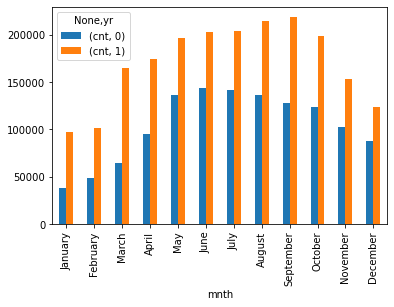

In [11]:
pt = df.pivot_table(index=['mnth'],columns=['yr'],values=['cnt'],aggfunc='sum')
pt.plot.bar()

<AxesSubplot:xlabel='weekday'>

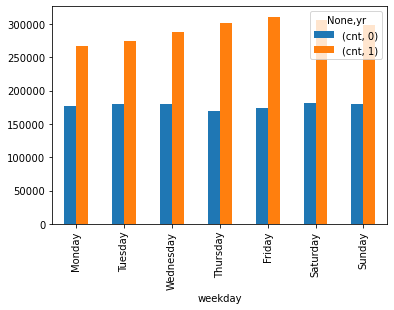

In [12]:
pt = df.pivot_table(index=['weekday'],columns=['yr'],values=['cnt'],aggfunc='sum')
pt.plot.bar()

### Pairplot

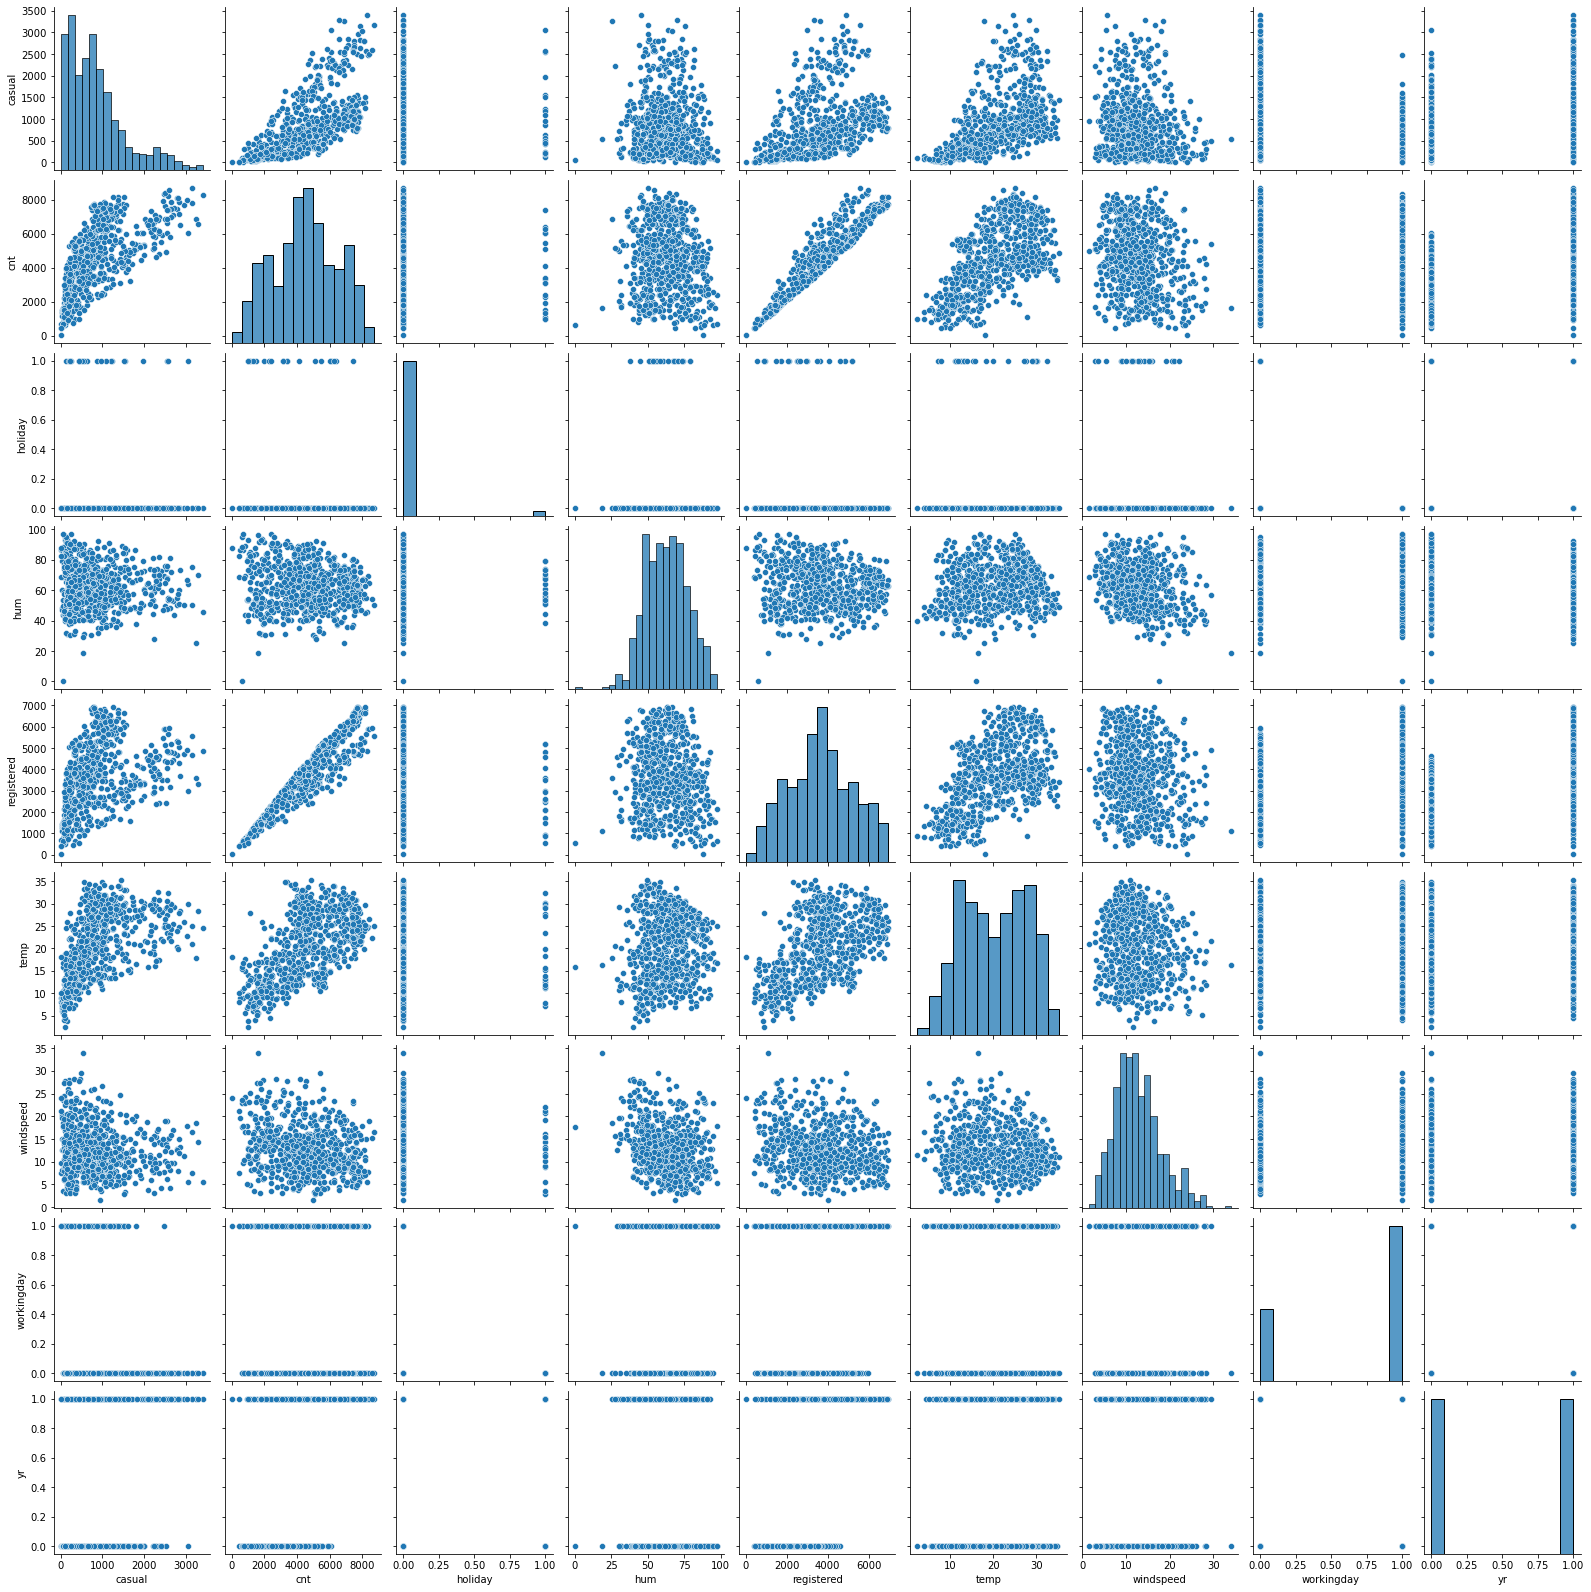

In [13]:
sns.pairplot(df)

### HeatMap

<AxesSubplot:>

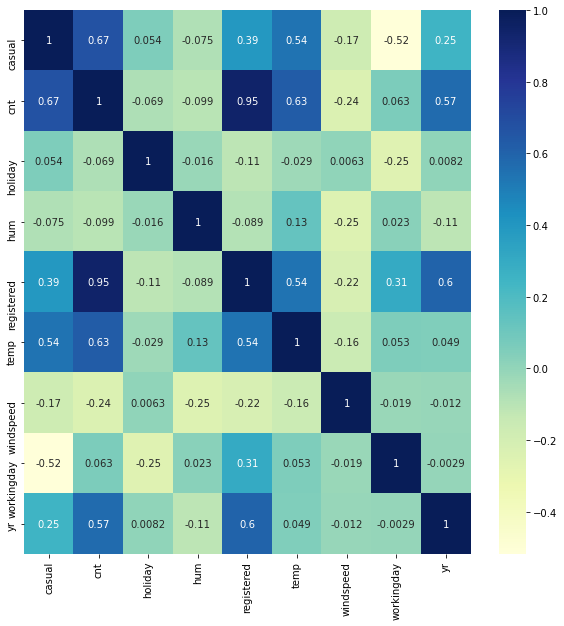

In [14]:
plt.figure(figsize=(10,10))
sns.heatmap(df.corr(),annot=True,cmap="YlGnBu")

### Pattern of total rentals 
- 2019 has seen an increase in total rentals.
- 2018 has peak rental counts in May,June,July where as 2019 has seen spike in August, September,October
- 2018 has almost same distribution of rental counts through out the week where as 2019 has seen little spike during Friday and Saturday

### Target variable correlation

- temp has highest positive correlation 
- windspeed has highest negative correlation 

## Step 2 : Data Preparation For Modelling

### Dropping related variables

#### Since cnt = registered + casual , Keeping cnt column and removing registered and casual columns

In [15]:
df_m = df[df.columns.difference(['casual','registered'])]

### Dummy variables

In [16]:
season_dummies = pd.get_dummies(df_m['season'],drop_first=True)
weather_dummies = pd.get_dummies(df_m['weathersit'],drop_first=True)
weekday_dummies = pd.get_dummies(df_m['weekday'],drop_first=True)
month_dummies = pd.get_dummies(df_m['mnth'],drop_first=True)

In [17]:
month_dummies.head()

,February,March,April,May,June,July,August,September,October,November,December
0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0


### Dummy variables concatenation and dropping categorical columns

In [18]:
df1 = pd.concat([df_m,season_dummies,weather_dummies,weekday_dummies,month_dummies],axis=1)
df1 = df1[df1.columns.difference(['season','weathersit','weekday','mnth'])]
df1.head()

,April,August,December,February,Friday,Heavy rain,July,June,Light snow,March,...,cnt,fall,holiday,hum,summer,temp,windspeed,winter,workingday,yr
0,0,0,0,0,0,0,0,0,0,0,...,985,0,0,80.5833,0,14.110847,10.749882,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,801,0,0,69.6087,0,14.902598,16.652113,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,1349,0,0,43.7273,0,8.050924,16.636703,0,1,0
3,0,0,0,0,0,0,0,0,0,0,...,1562,0,0,59.0435,0,8.200000,10.739832,0,1,0
4,0,0,0,0,0,0,0,0,0,0,...,1600,0,0,43.6957,0,9.305237,12.522300,0,1,0


## Step 3 : data split and rescaling

### train test split

In [19]:
train,test = train_test_split(df1,train_size=0.7,random_state=100)
print(train.shape)
print(test.shape)

(510, 30)
(220, 30)


### Rescaling - Normalization

In [20]:
scaler =  MinMaxScaler()
list = ['cnt','hum','temp','windspeed']
train[list] = scaler.fit_transform(train[list])
train.head()

,April,August,December,February,Friday,Heavy rain,July,June,Light snow,March,...,cnt,fall,holiday,hum,summer,temp,windspeed,winter,workingday,yr
576,0,0,0,0,0,0,1,0,0,0,...,0.827658,1,0,0.725633,0,0.815169,0.264686,0,1,1
426,0,0,0,0,0,0,0,0,0,1,...,0.465255,0,0,0.640189,0,0.442393,0.255342,0,0,1
728,0,0,1,0,0,0,0,0,0,0,...,0.204096,0,0,0.498067,0,0.245101,0.663106,0,0,1
482,1,0,0,0,0,0,0,0,0,0,...,0.482973,0,0,0.504508,1,0.395666,0.188475,0,0,1
111,1,0,0,0,0,0,0,0,0,0,...,0.191095,0,0,0.751824,1,0.345824,0.380981,0,1,0


## Step 4 : Training the model (Manual)

#### Regression model on all predictors

In [21]:
Y_train = train.pop('cnt')
X_train = train

X_train_sm = sm.add_constant(X_train)
reg = sm.OLS(Y_train,X_train_sm)
reg_model = reg.fit()

reg_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    cnt   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.844
Method:                 Least Squares   F-statistic:                     103.2
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          3.00e-181
Time:                        17:13:57   Log-Likelihood:                 527.03
No. Observations:                 510   AIC:                            -998.1
Df Residuals:                     482   BIC:                            -879.5
Df Model:                          27                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1763      0.030      5.797      0.000       0.117       0.236
April          0.0633      0.034      1.885      0.060      -0.003       0.129
August         0.0837      0.042      2.009      0.045       0.002       0.166
December       0.0190      0.026      0.718      0.473      -0.033       0.071
February       0.0309      0.021      1.497      0.135      -0.010       0.071
Friday         0.0019      0.011      0.172      0.864      -0.020       0.023
Heavy rain -2.817e-16   1.37e-16     -2.061      0.040    -5.5e-16   -1.32e-17
July           0.0295      0.044      0.672      0.502      -0.057       0.116
June           0.0679      0.039      1.752      0.080      -0.008       0.144
Light snow    -0.2558      0.026     -9.699      0.000      -0.308      -0.204
March          0.0646      0.022      2.888      0.004       0.021       0.109
May            0.0880      0.036      2.433      0.015       0.017       0.159
Mist          -0.0596      0.010     -5.709      0.000      -0.080      -0.039
November       0.0234      0.033      0.714      0.476      -0.041       0.088
October        0.0709      0.034      2.055      0.040       0.003       0.139
Saturday       0.0110      0.011      0.987      0.324      -0.011       0.033
September      0.1493      0.037      3.997      0.000       0.076       0.223
Sunday         0.0542      0.015      3.732      0.000       0.026       0.083
Thursday       0.0055      0.011      0.524      0.600      -0.015       0.026
Tuesday       -0.0099      0.010     -1.021      0.308      -0.029       0.009
Wednesday     -0.0069      0.011     -0.621      0.535      -0.029       0.015
fall           0.0448      0.030      1.496      0.135      -0.014       0.104
holiday       -0.0423      0.024     -1.792      0.074      -0.089       0.004
hum           -0.1515      0.039     -3.929      0.000      -0.227      -0.076
summer         0.0878      0.024      3.721      0.000       0.041       0.134
temp           0.4454      0.046      9.628      0.000       0.354       0.536
windspeed     -0.1860      0.026     -7.226      0.000      -0.237      -0.135
winter         0.1525      0.026      5.873      0.000       0.101       0.203
workingday     0.0438      0.009      4.680      0.000       0.025       0.062
yr             0.2324      0.008     28.819      0.000       0.217       0.248
==============================================================================
Omnibus:                       83.722   Durbin-Watson:                   2.049
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              231.841
Skew:                          -0.799   Prob(JB):                     4.53e-51
Kurtosis:                       5.891   Cond. No.                     1.24e+16
==============================================================================

N

### VIF

In [22]:
vif_df = pd.DataFrame()
vif_df['Predictors'] = X_train.columns
vif_df['vif'] = [variance_inflation_factor(X_train.values,i) for i in range(X_train.shape[1])]
vif_df['vif'] = round(vif_df['vif'],2)
vif_df = vif_df.sort_values(by='vif',ascending = False)
vif_df

,Predictors,vif
19,Wednesday,inf
21,holiday,inf
27,workingday,inf
4,Friday,inf
18,Tuesday,inf
17,Thursday,inf
14,Saturday,inf
24,temp,46.87
22,hum,20.66
20,fall,15.35


##### There are 21 columns with high values of VIF. Taking RFE approach to eliminate columns for which we have high values of multicollinearity

#### RFE (Recursive Feature Elimination)

In [23]:
lreg = LinearRegression()
lreg.fit(X_train,Y_train)
#Selecting 15 out of 30 columns
rfe = RFE(lreg,15)
rfe = rfe.fit(X_train,Y_train)

In [24]:
tuple(zip(X_train.columns,rfe.support_,rfe.ranking_))

(('April', False, 4),
 ('August', True, 1),
 ('December', False, 9),
 ('February', False, 6),
 ('Friday', False, 14),
 ('Heavy rain', False, 15),
 ('July', False, 7),
 ('June', False, 5),
 ('Light snow', True, 1),
 ('March', False, 2),
 ('May', False, 3),
 ('Mist', True, 1),
 ('November', False, 8),
 ('October', True, 1),
 ('Saturday', False, 12),
 ('September', True, 1),
 ('Sunday', True, 1),
 ('Thursday', False, 13),
 ('Tuesday', False, 10),
 ('Wednesday', False, 11),
 ('fall', True, 1),
 ('holiday', True, 1),
 ('hum', True, 1),
 ('summer', True, 1),
 ('temp', True, 1),
 ('windspeed', True, 1),
 ('winter', True, 1),
 ('workingday', True, 1),
 ('yr', True, 1))

#### columns selected

In [25]:
col = X_train.columns[rfe.support_]
col

Index(['August', 'Light snow', 'Mist', 'October', 'September', 'Sunday',
       'fall', 'holiday', 'hum', 'summer', 'temp', 'windspeed', 'winter',
       'workingday', 'yr'],
      dtype='object')

#### Columns dropped for multicollinearity

In [26]:
X_train.columns[~rfe.support_]

Index(['April', 'December', 'February', 'Friday', 'Heavy rain', 'July', 'June',
       'March', 'May', 'November', 'Saturday', 'Thursday', 'Tuesday',
       'Wednesday'],
      dtype='object')

In [27]:
X_train_rfe = sm.add_constant(X_train[col])
lrmodel = sm.OLS(Y_train,X_train_rfe).fit()
print(lrmodel.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     183.9
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          5.17e-191
Time:                        17:16:01   Log-Likelihood:                 519.44
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     494   BIC:                            -939.1
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1952      0.029      6.790      0.0

#### column 'fall' has 0.184 p value which is high enough to delete

In [28]:
X_train_rfe_new = X_train_rfe.drop(['fall'],axis=1)

#### building model again

In [30]:
lrmodel2 = sm.OLS(Y_train,X_train_rfe_new).fit()
print(lrmodel2.summary())

                            OLS Regression Results                            
Dep. Variable:                    cnt   R-squared:                       0.848
Model:                            OLS   Adj. R-squared:                  0.843
Method:                 Least Squares   F-statistic:                     196.6
Date:                Sat, 22 Feb 2025   Prob (F-statistic):          8.70e-192
Time:                        17:17:03   Log-Likelihood:                 518.52
No. Observations:                 510   AIC:                            -1007.
Df Residuals:                     495   BIC:                            -943.5
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1948      0.029      6.769      0.0

#### Checking VIF values again

In [32]:
vif_df = pd.DataFrame()
vif_df['Predictors'] = X_train_rfe_new.columns
vif_df['vif'] = [variance_inflation_factor(X_train_rfe_new.values,i) for i in range(X_train_rfe_new.shape[1])]
vif_df['vif'] = round(vif_df['vif'],2)
vif_df = vif_df.sort_values(by='vif',ascending = False)
vif_df

,Predictors,vif
0,const,53.47
13,workingday,1.88
8,hum,1.87
6,Sunday,1.79
12,winter,1.71
10,temp,1.59
3,Mist,1.56
4,October,1.49
1,August,1.46
9,summer,1.38


### Residual analysis on Train set

In [33]:
y_train_pred = lrmodel2.predict(X_train_rfe_new)

<AxesSubplot:ylabel='Density'>

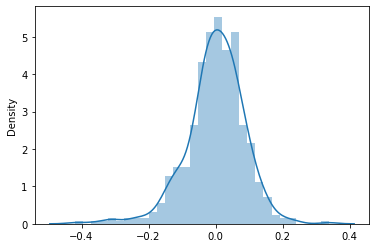

In [34]:
res = Y_train-y_train_pred
sns.distplot(res)

In [35]:
r2_score(y_true = Y_train, y_pred = y_train_pred)

0.8475442609382655

### Prediction and Evaluation on test set

In [36]:
scaler =  MinMaxScaler()
list = ['cnt','hum','temp','windspeed']
test[list] = scaler.fit_transform(test[list])
test.head()

,April,August,December,February,Friday,Heavy rain,July,June,Light snow,March,...,cnt,fall,holiday,hum,summer,temp,windspeed,winter,workingday,yr
184,0,0,0,0,0,0,1,0,0,0,...,0.704300,1,1,0.534223,0,0.837241,0.149393,0,0,0
535,0,0,0,0,0,0,0,1,0,0,...,0.725421,0,0,0.470417,1,0.911423,0.231142,0,1,1
299,0,0,0,0,1,0,0,0,0,0,...,0.278853,0,0,0.777843,0,0.496221,0.443398,1,1,0
221,0,1,0,0,0,0,0,0,0,0,...,0.545512,1,0,0.236659,0,0.890387,0.449707,0,1,0
152,0,0,0,0,1,0,0,1,0,0,...,0.569148,0,0,0.070765,1,0.821739,0.682387,0,1,0


In [37]:
Y_test = test.pop('cnt')
X_test = test

X_test_sm = sm.add_constant(X_test)

In [38]:
y_test_pred = lrmodel2.predict(X_test_sm[X_train_rfe_new.columns])

In [39]:
res_test = y_test_pred - Y_test

In [40]:
r2_score(y_true = Y_test, y_pred = y_test_pred)

0.8136358792412071

### Residual analysis on test test

<AxesSubplot:ylabel='Density'>

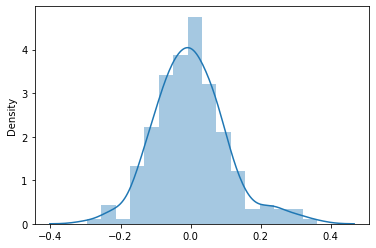

In [41]:
sns.distplot(res_test)

# Observations
## Test set RSquare shows that the model is generalized enough even with high train RSquare and F-Statistic

### Train Set 
- RSquare : 0.85
- F - Statistic : 196.6

### Test Set
- RSquare : 0.82
- Variation with test set - 3 %

## Equation of best fit line from model is 
$cnt = 0.0557*August -0.247* (Light Snow) - 0.0568 * Mist + 0.0385 * October + 0.125 * September - 0.0557 * Holiday -0.17 * hum + 0.1049 * summer + 0.53 * temp - 0.185 * windspeed + 0.135 * winter + 0.0442 * workingday + 0.229 * yr$

## Features having positive coefficients
- August,October,September,Sunday,Summer,temp,winter,working day, year

## Features having negative coefficients
- Light snow, Mist, holiday,hu, windspeed